<a href="https://colab.research.google.com/github/mb1te/SMPR/blob/main/SMPR_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ЗАДАНИЕ 12. СЕТЬ РАДИАЛЬНЫХ БАЗИСНЫХ ФУНКЦИЙ.**

Пусть классы являются смесями распределений.

В таком случае функция правдоподобия $p(x) = \sum\limits_{i = 1}^k w_i p_i(x)$ и $\sum\limits_{i=1}^k w_i = 1$, $p_j(x)$  функция правдоподобия $j$-ой смеси, $w_j$ - ее априорная вероятность.  Функции правдоподобия принадлежат параметрическому семейству распределений $\phi(x, \theta)$ и отличаются только значениями параметра $p_j (x) = \phi(x; \theta_j)$.

Задача разделения смеси заключается в том, чтобы, имея выборку $X^m$ случайных и независимых наблюдений из смеси $p(x)$, зная число $k$ и функцию $\phi$ оценить вектор параметров $\Theta = (w_1, ..., w_k, \theta_1, ..., \theta_k)$.

Для разделения смесей будем использовать $EM$-алгоритм.

**E-шаг.** 

Обозначим через $p(x, \theta_j)$ плотность вероятности того, что объект $x$
получен из $j$-й компоненты смеси.

$p(x, \theta_j) = p(x) P(\theta_j | x) = w_j p_j(x)$

Обозначим $g_{ij} = P(\theta_j | x_i)$. Это неизвестная апостериорная вероятность того, что обучающий объект $x_i$ получен из $j$-й компоненты смеси.

$\displaystyle g_{ij} = \frac{w_j p_j(x_i)}{\sum\limits_{s=1}^k w_s p_s(x_i)}$

**M-шаг.** 

Зная значения скрытых переменных $g_{ij}, принцип максимума правдоподобия приводит к оптимизационной задаче.

$
\begin{cases}
Q(\Theta) = ln \prod\limits_{i=1}^m p(x_i) = \sum_{i=1}^m ln \sum_{j=1}^k w_j p_j(x_i) \rightarrow \max\limits_\Theta \\ 
\sum\limits_{j=1}^k w_j = 1
\end{cases}
$

Путем несложных преобразований получаем: $\theta_j = \arg \max\limits_\theta \sum\limits_{i=1}^m g_{ij} \,\, ln\, \phi(x_i; \theta)$.

$ЕМ$-алгоритм с фиксированным числом компонент:

$X^m$ - выборка

$k$ — число компонент смеси;

$\Theta = (w_j, \theta_j)_{j=1}^k$ — вектор параметров смеси.

$\delta$ — параметр критерия останова.

1. do

  1.1 $E$-шаг:
  
  $\displaystyle g_{ij}^0 = g_{ij}; g_{ij} = \frac{w_j \phi(x_i; \theta)}{\sum\limits_{s=1}^k w_s \phi(x_i; \theta_s)}$

  1.2 $M$-шаг:

  $\displaystyle \theta_j = \arg \max\limits_{\theta} \sum\limits_{i=1}^m g_{ij} \, ln \, \phi(x_i; \theta)$

  $\displaystyle w_j = \frac{1}{m} \sum\limits_{i=1}^m g_{ij}$

2. while $\max\limits_{i,j}|g_{ij}^0 - g_{ij}| > \delta$

$ЕМ$-алгоритм с последовательным добавлением компонент:

$X^m$ - выборка

$R$ — максимальный допустимый разброс правдоподобия объектов;

$m_0$ — минимальная длина выборки, по которой можно восстановить
плотность;

$\delta$ — параметр критерия останова

$k$ — число компонент смеси;

$\Theta = (w_j , \theta_j)_{j=1}^k$ — веса и параметры компонент.

1. $\theta_1 = \arg \max\limits_{\theta} \sum\limits_{i=1}^m ln \,\phi(x_i; \theta)$.
2. for $k$ in $2..m$:    
  2.1 $U = \{x_i \in X^m | p(x_i) < \max\limits_s p(x_s)/R\}$;

  2.2 if $|U| < m_0 \Rightarrow$ break

3. $\displaystyle \theta_k= \arg \max\limits_{\theta} \sum\limits_{i \in U} ln \,\phi(x_i; \theta); w_k = \frac{1}{m} |U|;$

4. $EM(X^m, k, \Theta, \delta);$


Класс, реализующий разделение смесей $EM$-алгоритмом:

In [1]:
import pandas as pd
import numpy as np

"""
Класс, реализующий разделение смесей EM-алгоритмом
"""
class MixtureSplitter:
    # максимальное число компонент
    MAX_K = 10

    """
    Метод находит мат ожидание по выборке
    """ 
    def get_mu(self, xl):
        return np.array(xl.mean())

    """
    Метод находит ковариацию по выборке
    """
    def get_cov(self, xl, mu):
        m, k = xl.shape
        cov = np.zeros((k, k))
        for i in range(m):
            cur = xl.values[i]
            cov += np.array([cur - mu]) * np.array([cur - mu]).T
        return cov / (m - 1)

    """
    Метод считает плотность смеси распределений
    """
    def get_phi(self, xl, theta, w):
        ans = []
        for i in range(len(xl)):
            cur = 0
            x = xl.values[i]
            for j in range(len(theta)):
                cur += w[j] * self.p(x, theta[j]['mu'], theta[j]['cov'])
            ans.append((i, cur.flatten()[0]))
        return ans

    """
    Метод находит плотность нормально распределенной величины
    """
    def p(self, x, mu, cov):
        xx = np.array([x - mu])
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)
        n = len(x)
        return 1 / (np.sqrt((2 * np.pi)**n) * det) * np.exp(-0.5 * np.matmul(np.matmul(xx, inv), xx.T))


    """
    Реализация ЕМ-алгоритма с последовательным добавлением компонент
    """
    def EM_large(self, xl, m_0, delta, r):
        m, fc = xl.shape
        self.classes = np.unique(self.y)

        mu = self.get_mu(xl)
        cov = self.get_cov(xl, mu)

        theta = [{'mu': mu, 'cov': cov}]
        k = 1
        w = [1]

        for step in range(1, self.MAX_K + 1):
            cur_phi = self.get_phi(xl, theta, w)
            p_max = max(cur_phi, key=lambda z: z[1])[1] * r
            u = list(map(lambda z: z[0], filter(lambda z: z[1] < p_max, cur_phi)))

            if len(u) < m_0:
                break

            k = step
            w_k = len(u) / m
            w = list(map(lambda z: z * (1 - w_k), w))
            w.append(w_k)
            mu = self.get_mu(xl.iloc[u])
            cov = self.get_cov(xl.iloc[u], mu)
            theta.append({'mu': mu, 'cov': cov})

            w, theta = self.EM(xl, k, theta, delta, w)

        return w, theta


    """
    Метод реализует ЕМ-алгоритм с фиксированным числом компонент
    """
    def EM(self, xl, k, theta, delta, w):
        m, fc = xl.shape
        g = np.zeros((m, k))
        g0 = np.zeros((m, k))

        MAX_STEPS = 100

        for step in range(1, MAX_STEPS + 1):
            #E-step
            for i in range(m):
                cur = xl.values[i]
                for j in range(k):
                    g0[i][j] = g[i][j]
                    nom = w[j] * self.p(cur, theta[j]['mu'], theta[j]['cov'])
                    denom = np.sum([self.p(cur, theta[s]['mu'], theta[s]['cov']) for s in range(k)])
                    g[i][j] = nom / denom

            #M-step
            for j in range(k):
                w[j] = np.sum(g[:, j]) / m

                mu = np.zeros(fc)
                for i in range(fc):
                    mu[i] = np.dot(g[:,j], xl.values[:, i]) / (m * w[j])

                cov = np.zeros((2, 2))
                cov[0][0] = np.dot(g[:, j], (xl.values[:, 0] - mu[0])**2) / (m * w[j])
                cov[1][1] = np.dot(g[:, j], (xl.values[:, 1] - mu[1])**2) / (m * w[j])

                theta[j] = {'mu': mu, 'cov': cov}

            if self.dif(g, g0) < delta:
                break

        return w, theta

    def dif(self, a, b):
        return np.sum(abs(a - b))

Для предсказания класса объектов будем использовать сеть радиальных функций (RBF):

$a(x) = \arg \max\limits_{y \in Y} \lambda_y P_y \sum\limits_{j = 1}^{k_y} w_{yj} p_{yj}(x)$.

Разделяем смеси EM-алгоритмом и получаем $p_{yj}(x)$ и $w_{yj}(x)$.

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

"""
Класс реализует сеть радиальных функций. Наследует класс разделения смесей.
"""
class RadialBasisFunction(MixtureSplitter):
    def __init__(self, X, y, delta, r):
        self.X = X
        self.y = y

        self.w = {}
        self.theta = {}

        self.w[0], self.theta[0] = self.EM_large(X.iloc[y[y == 0].index], np.floor(len(y[y == 0]) / 3), delta, r)
        self.w[1], self.theta[1] = self.EM_large(X.iloc[y[y == 1].index], np.floor(len(y[y == 1]) / 3), delta, r)

        self.P = {}
        self.P[0] = len(y[y == 0]) / len(y)
        self.P[1] = len(y[y == 1]) / len(y)

    """
    Метод рассчитывет вероятности принадлежности объекта каждому классу
    и возвращает наиболее вероятный
    """
    def predict(self, obj):
        posteriors = []
        classes = []

        for c in self.classes:
            prior = self.P[c]
            theta = self.theta[c]
            w = self.w[c]
            probability = 0
            for j in range(len(theta)):
                probability += w[j] * self.p(obj, theta[j]['mu'], theta[j]['cov'])
            posteriors.append(prior * probability)
            classes.append(c)

        return classes[np.argmax(posteriors)]


    """
    Метод рисует карту классификации [0,1] x [0,1]
    """
    def draw_classification_map(self):
        i, j = 'x', 'y'
        color = {0: 'blue', 1: 'red'}
        fig, ax = plt.subplots()

        for xi in np.arange(0, 1, 0.03):
            for yi in np.arange(0, 1, 0.03):
                cat = self.predict([xi, yi])
                plt.scatter(xi, yi, color='none', edgecolor=color[cat])

        for ind in range(len(self.X)):
            xi = self.X[i].values[ind]
            yi = self.X[j].values[ind]
            cat = self.y.values[ind]
            clr = color[cat]
            plt.scatter(xi, yi, color=clr)

        plt.legend(handles=[Patch(color=color[key], label=key) for key in color])

        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

Сгенерируем смесь распределений:

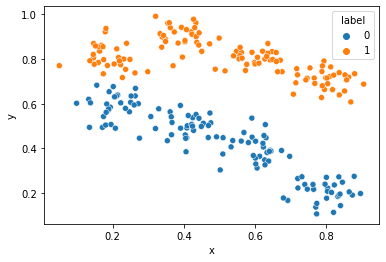

In [8]:
import numpy as np
import pandas as pd

GROUP_SIZE = 30


"""
Функция generate_array генерирует массив точек заданного размера
согласно заданным параметрам нормального распределения
"""
def generate_array(m1, d1, m2, d2,  size=GROUP_SIZE):
    return np.concatenate(
        (
            np.random.normal(m1, d1, size=size),
            np.random.normal(m2, d2, size=size)
        )
    )


df = pd.DataFrame(
    {
        'x': np.concatenate((
            generate_array(0.2, 0.05, 0.4, 0.05),
            generate_array(0.4, 0.05, 0.6, 0.05),
            generate_array(0.6, 0.05, 0.8, 0.05),
            generate_array(0.8, 0.05, 0.2, 0.05),
        )),
        'y': np.concatenate((
            generate_array(0.6, 0.05, 0.9, 0.05),
            generate_array(0.5, 0.05, 0.8, 0.05),
            generate_array(0.4, 0.05, 0.7, 0.05),
            generate_array(0.2, 0.05, 0.8, 0.05),
        )),
        'label': np.array(([0] * GROUP_SIZE + [1] * GROUP_SIZE) * 4)
    }
)

X = df[['x', 'y']]
y = df.label

import seaborn as sns
sns.scatterplot(data=df, x='x', y='y', hue='label')

Карта классификации:

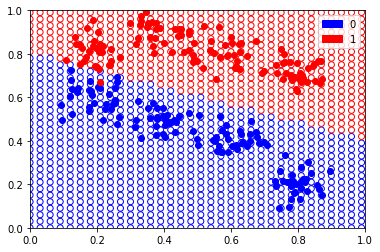

In [6]:
RBF = RadialBasisFunction(X, y, 0.0000001, 0.1)
RBF.draw_classification_map()